In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import *
from plotting_utils import *
from lineplots import plotsd
from stabilizer_utils import *
from recalibration_utils import *
from session_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


min_nblocks    = 3
max_ndays      = 1e99
participant    = 'T5'


FILE_DIR       = '/oak/stanford/groups/shenoy/gwilson/nonstationarities/' + participant + '/'
fig_path       = '/home/users/ghwilson/projects/nonstationarities/figures/'
filelist       = glob.glob(FILE_DIR + 'historical/*')
filelist.extend(glob.glob(FILE_DIR + 'new/*'))

sessions_check = np.load('../utils/misc_data/OldSessions_check.npy', allow_pickle = True).item()
files          = get_Sessions(filelist, min_nblocks,  manually_remove = None)
pairs          = get_SessionPairs(files, max_ndays = max_ndays)
n_pairs        = len(pairs)

In [ ]:
from CosineTuning import unit_vector, fitEncodingMatrix, angle_between, getAngles
from sklearn.linear_model import Ridge


# general settings:
np.random.seed(42)
diffs           = list()
task            = None
train_size      = 0.67
sigma           = 2


cos_scores = np.zeros((len(uniqueFiles)))

# First calculate encoding and decoding weights independently for each session:
for i, file in enumerate(uniqueFiles):
    session = DataStruct(file, causal_filter = sigma, alignScreens = True)
    
    # obtain features and cursorError targets:
    train_x, test_x, train_y, test_y  = getTrainTest(session, train_size = train_size, sigma = None, blocks = None, task = task, returnFlattened = True)    
    train_x, test_x   = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
    train_y           = np.concatenate(train_y)
    test_y            = np.concatenate(test_y)
    _, models         = fitEncodingMatrix(train_y, train_x, fitMean = False)
    
    mask = np.linalg.norm(test_y, axis = 1) > 0
    angles = getAngles(test_y[mask, :], returnFullAngle = True)
    
    cos_scores[i] = np.median([cos.score(angles[mask], test_x[:, i]) for i, cos in enumerate(models)])
    
    if (i + 1) % 10 == 0:
        print(i + 1, '/', len(uniqueFiles))

In [2]:
from CosineTuning import unit_vector, fitEncodingMatrix, angle_between
from sklearn.linear_model import Ridge


# general settings:
np.random.seed(42)
diffs           = list()
task            = None
train_size      = 0.67
sigma           = 2


uniqueFiles     = np.unique(np.concatenate(pairs))
nUnique         = len(uniqueFiles)
dates           = list()
scores          = list()
weightsD        = list()
weightsE        = list()

angles          = np.zeros((n_pairs, 2, 2)) # pair, encoding/decoding weights, x/y velocity
diffs           = np.zeros((n_pairs))       # number of days separating sessions 

# First calculate encoding and decoding weights independently for each session:
for file in uniqueFiles:
    session = DataStruct(file, causal_filter = sigma, alignScreens = True)
    
    # obtain features and cursorError targets:
    train_x, test_x, train_y, test_y  = getTrainTest(session, train_size = train_size, sigma = None, blocks = None, task = task, returnFlattened = True)    
    train_x, test_x   = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
    train_y           = np.concatenate(train_y)
    test_y            = np.concatenate(test_y)
    #score, decoder    = traintest_DecoderSupervised([train_x], [test_x], [train_y], [test_y], meanRecal = False)
    decoder           = Ridge(alpha = 1e7).fit(train_x, train_y)
    score             = decoder.score(test_x, test_y)
    encoder           = fitEncodingMatrix(train_y, train_x, fitMean = False)
    
    dates.append(session.date)
    scores.append(score)
    weightsD.append(decoder)
    weightsE.append(encoder)
    
# now compare weight similarities across sessions: 
for i, (A_file, B_file) in enumerate(pairs):
    A_date   = A_file.split('t5.')[1].split('.mat')[0]
    B_date   = B_file.split('t5.')[1].split('.mat')[0]
    diffs[i] = daysBetween(A_date, B_date)

    A_ind  = np.where(np.in1d(dates, A_date))[0][0]
    B_ind  = np.where(np.in1d(dates, B_date))[0][0]

    for j in range(2):
        angles[i, 0, j]  = angle_between(weightsD[A_ind].coef_[j, :], weightsD[B_ind].coef_[j, :])
        angles[i, 1, j]  = angle_between(weightsE[A_ind][j, :], weightsE[B_ind][j, :])

    if (i + 1) % 200 == 0:
        print(i+ 1, '/', len(pairs))



/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


200 / 2926
400 / 2926
600 / 2926
800 / 2926
1000 / 2926
1200 / 2926
1400 / 2926
1600 / 2926
1800 / 2926
2000 / 2926
2200 / 2926
2400 / 2926
2600 / 2926
2800 / 2926


In [3]:


def plotAngleDifferences(x, angles, colors, labels, alpha = None):
    '''Plot angular differences across time. Inputs are:
    
        x (1D float array)    - nSamples of x values 
        angles (2D float)     - nSamples x nClasses of angles 
        colors (1D str array) - nClasses of colors 
        labels (1D str array) - nClasses of labels
        
    '''
    
    nClasses = angles.shape[1]
    
    for i in range(nClasses):
        y = angles[:, i]

        plt.scatter(x, y, alpha = alpha, color = colors[i], label = labels[i])

        #poly = np.poly1d(np.polyfit(x, y, deg = 2))
        #plt.plot(np.arange(max(x)), poly(np.arange(max(x))), color = colors[i])

        #bootstrap_CI = np.zeros((len(np.arange(max(x))), n_iters))
        #for j in range(n_iters):
        #    bs_inds = np.random.choice(len(x), len(x), replace = True)
        #    poly    = np.poly1d(np.polyfit(x[bs_inds], y[bs_inds], deg = 2))
        #    bootstrap_CI[:, j] = poly(np.arange(max(x)))

        #plotsd(bootstrap_CI.T, time_bins= np.arange(max(x)), color = colors[i])

    plt.ylabel('Tuning similarity (Cos $\theta$)')
    plt.axhline(0, c = 'k', linestyle = '--')
    plt.ylim([-1, 1])
    plt.legend()


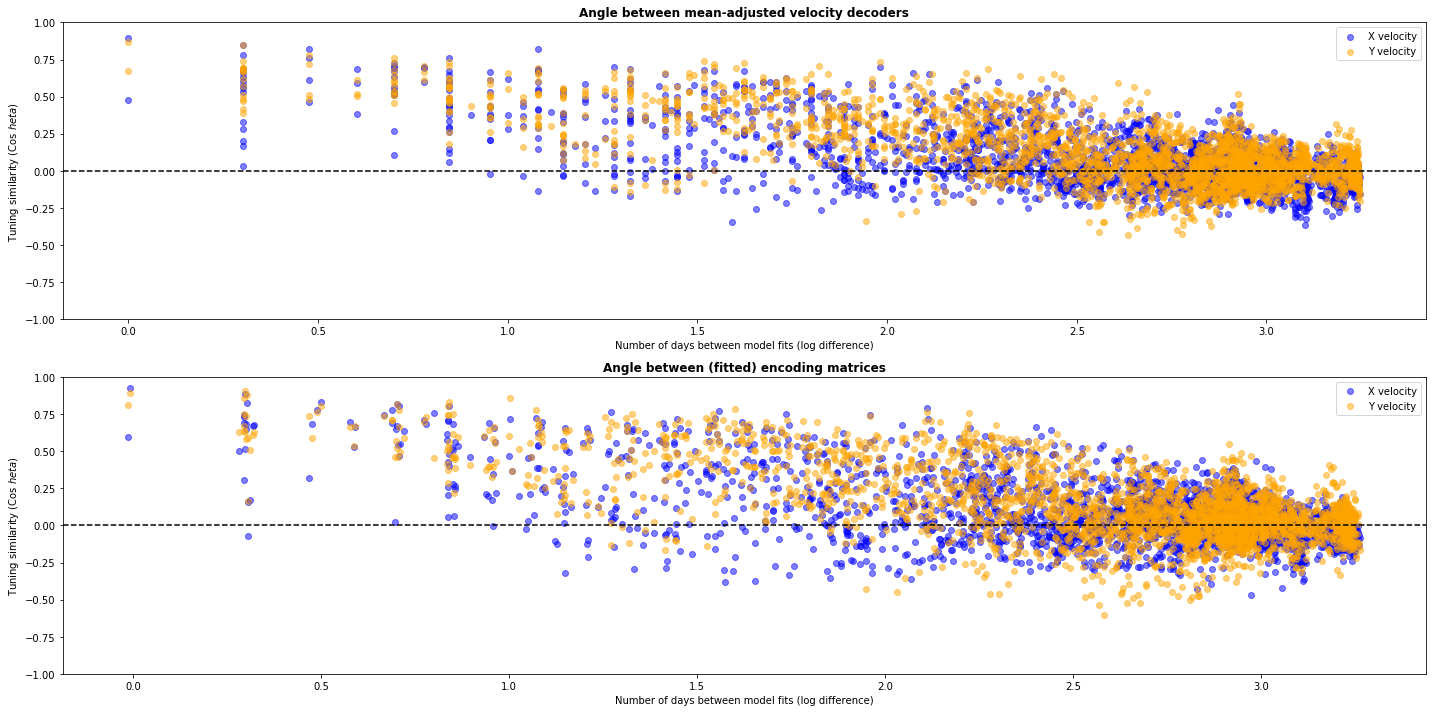

In [10]:
from scipy.signal import savgol_filter

figSize(10, 20)

n_iters   = 1000
colors    = ['b', 'orange']
labels    = ['X velocity', 'Y velocity']
alpha     = 0.5

#subselect = np.logical_and(scores[:, 0] > 0, scores[:, 1] > 0)
scores    = np.asarray(scores)
subselect = np.arange(scores.shape[0])
subselect = np.arange(n_pairs)

x         = diffs[subselect]
sort_idx  = np.argsort(x)
x         = np.log10(x[sort_idx])
y_vals   = np.cos(angles[subselect, :, :])[sort_idx, :, :]


# Decoders
plt.subplot(2, 1, 1)

plotAngleDifferences(x, y_vals[:, 0, :], colors, labels, alpha)
plt.xlabel('Number of days between model fits (log difference)')
plt.title('Angle between mean-adjusted velocity decoders', fontweight = 'bold')


# Encodings:
plt.subplot(2, 1, 2)

plotAngleDifferences(x, y_vals[:, 1, :], colors, labels, alpha)
plt.xlabel('Number of days between model fits (log difference)')
plt.title('Angle between (fitted) encoding matrices', fontweight = 'bold')


plt.tight_layout()

#plt.savefig(fig_path + 'SNR/T5_EncDec_Drift', format = 'pdf')
plt.show()


### Look at encoder drift model

Now we'll fit a linear model of our encoder drift across days with the formula:

$E' = \alpha E + \epsilon \ \ \ $     where $\epsilon \sim N(0, \sigma^{2}) $

This will help us determine plausible parameters for the closed-loop simulator by figuring out good values for the *shrinkage factor* $\alpha$ and noise model. Once we get the shrinkage factors for each pair of sessions, we can then fit some 
canonical shrinkage factor per day that helps compare these data across pairs (each pair may have e.g. 2 or 200 days apart). In this updated model, we have that:

$E^{(n)} = a^{n} E_{0} + \epsilon \ \ \ $ where $\epsilon \sim N(0, \sigma^{2} n * (\alpha^{n-1})^{2}) $

We can get this base shrinkage $\alpha$ value by performing linear regression on the observed shrinkages in log-space:

$\alpha_{x} \approx \hat{\alpha} = \exp(c \cdot x )$

$c = argmin_{a_{0}} ||\log(\alpha_{x}) - x * log(\alpha_{0}) ||^{2} $

Base alpha =  0.8967910961578965
Base alpha =  0.9229824191102518


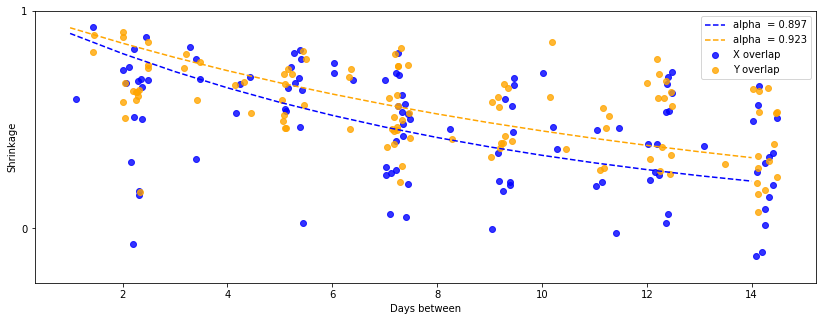

In [16]:
figSize(5, 14)
window = 14 # look at sessions up to two weeks apart
colors = ['b', 'orange']
labels = ['X overlap', 'Y overlap']


withinWindow      = np.where(diffs <= window)[0]
withinDiffs       = diffs[withinWindow]

for i in range(2):
    withinShrinkages  = np.cos(angles[withinWindow, 1, i])
    x                 = np.arange(1, max(withinDiffs) + 1)
   # predx    = np.vstack([withinDiffs, np.ones(len(withinDiffs))]).T
   # mult, c  = np.linalg.lstsq(predx, np.log(withinShrinkages + 0.5)[:, np.newaxis], rcond = None)[0]
   # ypred    = np.exp((mult * x) + c) - 0.5

    predx = withinDiffs[withinShrinkages > 0, np.newaxis]
    mult  = np.linalg.lstsq(predx, np.log(withinShrinkages[withinShrinkages > 0])[:, np.newaxis], rcond = None)[0][0][0]
    ypred = np.exp(mult * x) 
    
    alpha    = np.exp(mult)
    print('Base alpha = ', alpha)

    plt.scatter(withinDiffs + 0.5 * np.random.rand(*withinDiffs.shape), withinShrinkages, alpha = 0.8, color = colors[i], label = labels[i])
    
    plt.plot(x, ypred, color = colors[i], linestyle = '--', label = 'alpha  = ' + str(np.round(alpha, 3)))

plt.ylim([-0.25, 1])
plt.yticks([0, 1])
plt.xlabel('Days between')
plt.ylabel('Shrinkage')
plt.legend()
plt.savefig(fig_path + 'SNR/T5_Enc_drift_twoweeks', format = 'pdf')
plt.show()